In [1]:
import os
import copy

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm

from tqdm.notebook import tqdm
tqdm.pandas()

## EDA

Для построения рекомендательной системы был выбран "small" датасет с сайта https://nijianmo.github.io/amazon/index.html **"Video Games"**.

In [2]:
DATA_PATH = os.path.join(".", "data", "Video_Games.csv")

In [3]:
input_data = pd.read_csv(DATA_PATH, header=None, names=["item", "user", "rating", "date"])

In [4]:
input_data.head()

,item,user,rating,date
0,0439381673,A21ROB4YDOZA5P,1.0,1402272000
1,0439381673,A3TNZ2Q5E7HTHD,3.0,1399680000
2,0439381673,A1OKRM3QFEATQO,4.0,1391731200
3,0439381673,A2XO1JFCNEYV3T,1.0,1391731200
4,0439381673,A19WLPIRHD15TH,4.0,1389830400


In [5]:
input_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2565349 entries, 0 to 2565348
Data columns (total 4 columns):
 #   Column  Dtype  
---  ------  -----  
 0   item    object 
 1   user    object 
 2   rating  float64
 3   date    int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 78.3+ MB


Для ускорения работы, переведем колонки 'user' и 'item' в числовой формат

In [6]:
def encode_users_and_items(data, user_col='user', item_col='item'):
    data = copy.copy(data)
    user_encoder = LabelEncoder()
    item_encoder = LabelEncoder()

    data[user_col] = user_encoder.fit_transform(data[user_col])
    data[item_col] = item_encoder.fit_transform(data[item_col])

    return data, item_encoder, user_encoder

In [7]:
data, item_encoder, user_encoder = encode_users_and_items(input_data)

In [8]:
from IPython.display import display

def print_statistics(data):
    display(data['rating'].describe())
    print("*" * 50)

    print(f'Размер: {data.shape}')
    print("*" * 50)

    print('Пропущенные значения:')
    display(data.isna().sum())
    print("*" * 50)

    unique_items = data['item'].nunique()
    unique_users = data['user'].nunique()
    print(f"Количество уникальных товаров: {unique_items} ({unique_items / data.shape[0] * 100:.2f}%)")
    print(f"Количество уникальных юзеров: {unique_users} ({unique_users / data.shape[0] * 100:.2f}%)")
    print("*" * 50)

    (data['rating'].value_counts() / data.shape[0])\
        .plot(kind='bar', title="Ratings distribution", xlabel='Rating', ylabel='Percentage')
    plt.grid()
    plt.show()
    print("*" * 50)

    print('Сколько оценок ставят пользователи:')
    display(data.groupby('user').agg('count')['rating'].describe())
    print("*" * 50)

    print('Сколько оценок получает каждая игра:')
    display(data.groupby('item').agg('count')['rating'].describe())
    print("*" * 50)

count    2.565349e+06
mean     4.022095e+00
std      1.405936e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

**************************************************
Размер: (2565349, 4)
**************************************************
Пропущенные значения:


item      0
user      0
rating    0
date      0
dtype: int64

**************************************************
Количество уникальных товаров: 71982 (2.81%)
Количество уникальных юзеров: 1540618 (60.05%)
**************************************************


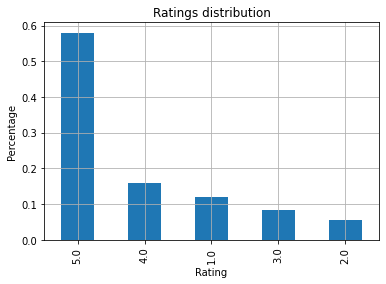

**************************************************
Сколько оценок ставят пользователи:


count    1.540618e+06
mean     1.665143e+00
std      2.892944e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      8.880000e+02
Name: rating, dtype: float64

**************************************************
Сколько оценок получает каждая игра:


count    71982.000000
mean        35.638757
std        140.211198
min          1.000000
25%          2.000000
50%          5.000000
75%         19.000000
max       7630.000000
Name: rating, dtype: float64

**************************************************


In [9]:
print_statistics(data)

### Выводы:
* Всего в датасете присутствует 2.565.349 оценки
* 71982 уникальных игр и 1.540.618 уникальных пользоватля
* В данных отсутствуют пропуски
* В среднем на одного пользователя приходится 1.7 оценки, а на одну игру чуть больше 35 оценок. Датасет достаточно сильно разряжен. Для ускорения работы сократим датасет на ~70% и отфильтруем юзеров, которые поставили меньше 2 оценок и товары, которые получили меньше 19 оценок

In [10]:
data_filtered = data[data.groupby('item')['item'].transform('size') > 19]
data_filtered = data_filtered[data_filtered.groupby('user')['user'].transform('size') > 2]

count    833969.000000
mean          4.203848
std           1.223682
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: rating, dtype: float64

**************************************************
Размер: (833969, 4)
**************************************************
Пропущенные значения:


item      0
user      0
rating    0
date      0
dtype: int64

**************************************************
Количество уникальных товаров: 17849 (2.14%)
Количество уникальных юзеров: 159651 (19.14%)
**************************************************


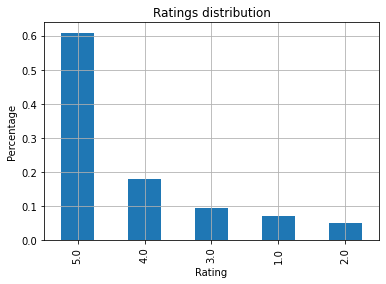

**************************************************
Сколько оценок ставят пользователи:


count    159651.000000
mean          5.223700
std           6.421379
min           3.000000
25%           3.000000
50%           4.000000
75%           5.000000
max         759.000000
Name: rating, dtype: float64

**************************************************
Сколько оценок получает каждая игра:


count    17849.000000
mean        46.723570
std         95.816846
min          1.000000
25%         11.000000
50%         20.000000
75%         44.000000
max       3157.000000
Name: rating, dtype: float64

**************************************************


In [11]:
print_statistics(data_filtered)

* После фильтрации в датасете осталось 833.969 строк, что сотсавляет ~32% от первональчного значения.
* Доля уникальных юзеров и товаров по отношению к величине всего набора данных снизилась, что говорит о меньшей разреженности
* В фильтрованном наборе данных, каждый пользователь в среднем ставит около 5 оценок, а каждая игра получает ~46 оценок
* Есть небольшие изменения в распределении оценок, но фундаментальных различий нет

## Train-test split

В данных присутствует время, поэтому логично при разделении данных на тренировочный и тестовый наборы учесть это: разделим данные таким образом, чтобы от каждого пользователя отложить в тестовый набор 20%  наиболее поздних по времени данных. При этом, если у пользователя меньше оценок для деления датасета в соотношении 80-20 (например, 3), то в тренировочный набор попадут 2 записи, а в тестовый 1. Такой подход не гарантирует, что финальное разбиение будет в точности соответствовать соотношению 80-20, скорее всего соотношение будет ближе к 75-25.

In [12]:
def train_test_split(
    data, ratio=0.2, user_col='user', item_col='item',
    rating_col='rating', time_col='date'
):
    def split_one_user(x, ratio=0.2):
        split_idx = int(x.shape[0] * (1 - ratio))
        train_ids = x.iloc[:split_idx, :].index
        x['train'] = np.isin(x.index, train_ids)
        return x
    
    data_copy = copy.copy(data)
    data_copy['train'] = 0
    data_copy = data_copy.sort_values(by=[time_col])
    grouped = data_copy.groupby(user_col)
    data_copy = grouped.progress_apply(split_one_user, ratio=ratio)
    
    x_train = data_copy[[user_col, item_col, rating_col]][data_copy['train']]
    x_test = data_copy[[user_col, item_col, rating_col]][~data_copy['train']]
    
    return x_train, x_test

In [13]:
x_train, x_test = train_test_split(data_filtered)

  0%|          | 0/159651 [00:00<?, ?it/s]

## Baseline model

В качестве бейзлайна возьмем стандартную user-based модель библиотеки surprise, обученную на всем тренировочном датасете

In [14]:
from surprise import Dataset, Reader
from surprise import BaselineOnly
from surprise import accuracy
from surprise.model_selection import KFold

reader = Reader(rating_scale=(1, 5))
train_data = Dataset.load_from_df(x_train, reader)
test_data = Dataset.load_from_df(x_test, reader)

In [15]:
trainset = train_data.build_full_trainset()
algo = BaselineOnly()
algo.fit(trainset)
predictions = algo.test(test_data.construct_testset(test_data.raw_ratings))
accuracy.rmse(predictions, verbose=True)

Estimating biases using als...
RMSE: 1.1353


1.1353040534724266

## Cross-validation scheme

Проверим 3 схемы валидации:
1. Первая будет сделана путем случайного разбиения на 3 фолда внутренними функциями библиотеки surprise
2. Используем TimeSeriesSplit (за основу возьмем реализацию sklearn, но адаптируем для датасетов surprise): это похоже на то, что сделано в функции train_test_split выше, но разбиение не будет учитывать каждого юзера в отдельности.
3. LeaveOneOut: от каждого юзера в testset будет попадать ровно 1 пример

In [16]:
class TimeSeriesSplit():
    """Time Series cross-validator
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals, in train/test sets.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <time_series_split>`.
    .. versionadded:: 0.18
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
        .. versionchanged:: 0.22
            ``n_splits`` default value changed from 3 to 5.
    max_train_size : int, default=None
        Maximum size for a single training set.
    test_size : int, default=None
        Used to limit the size of the test set. Defaults to
        ``n_samples // (n_splits + 1)``, which is the maximum allowed value
        with ``gap=0``.
        .. versionadded:: 0.24
    gap : int, default=0
        Number of samples to exclude from the end of each train set before
        the test set.
        .. versionadded:: 0.24
    """
    
    def __init__(self,
                 n_splits=5,
                 shuffle=False,
                 random_state=None):
        
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_state = random_state

    def split(self, data):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        data : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        Yields
        ------
        train : surprise
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        
        n_samples = len(data.raw_ratings)
        n_splits = self.n_splits
        n_folds = n_splits + 1
        
        test_size = n_samples // n_folds

        # Make sure we have enough samples for the given split parameters
        if n_folds > n_samples:
            raise ValueError(
                (f"Cannot have number of folds={n_folds} greater"
                 f" than the number of samples={n_samples}."))

        indices = np.arange(len(data.raw_ratings))
        test_starts = range(n_samples - n_splits * test_size,
                            n_samples, test_size)

        for test_start in test_starts:
            train_end = test_start
            raw_trainset = [data.raw_ratings[i] for i in indices[:train_end]]
            raw_testset = [data.raw_ratings[i] for i in indices[test_start:test_start + test_size]]
            
            trainset = data.construct_trainset(raw_trainset)
            testset = data.construct_testset(raw_testset)

            yield trainset, testset

In [17]:
from surprise.model_selection import LeaveOneOut

def make_cross_validation(data, algo, politic, n_splits=3, **algo_kwargs):
    if politic == "kfold":
        cv = KFold(n_splits=n_splits)
    elif politic == "loo":
        cv = LeaveOneOut(n_splits=n_splits)
    elif politic == "tss":
        cv = TimeSeriesSplit(n_splits=n_splits)
    
    algo = algo(**algo_kwargs)
    for trainset, testset in cv.split(data):
        predictions = algo.fit(trainset).test(testset)
        accuracy.rmse(predictions, verbose=True)

In [18]:
make_cross_validation(train_data, BaselineOnly, "loo")

Estimating biases using als...
RMSE: 1.1381
Estimating biases using als...
RMSE: 1.1365
Estimating biases using als...
RMSE: 1.1367


In [19]:
make_cross_validation(train_data, BaselineOnly, "kfold")

Estimating biases using als...
RMSE: 1.1073
Estimating biases using als...
RMSE: 1.1075
Estimating biases using als...
RMSE: 1.1041


In [20]:
make_cross_validation(train_data, BaselineOnly, "tss")

Estimating biases using als...
RMSE: 1.2349
Estimating biases using als...
RMSE: 1.1519
Estimating biases using als...
RMSE: 1.1475


### Выводы
* KFold имеет небольшой разброс, но занижает оценку ошибки по сравнением с бейзлайн моделью обученной на всем сете
* Схема основанная на времени имеет наибольший разброс, что не позволяет эффективно ее использовать. Скорее всего это связано с меньшим количеством данных для обучения для первых двух фолдов
* LeaveOneOut дает хорошее приближение метрики, полученной на отложенном датасете и имеет небольшой разброс. Для дальнейших исследований будем использовать именно эту схему

## Сравнение различных моделей

Для сравнения различных алгоритмов возьмем следующие:

* item_based KNN с метриками схожести cosine, msd и pearson (user_based в данном варианте датасета недоступна так как нет возможности хранить огромную матрицу 160k x 160k
* SVD
* CoClustering
* SlopeOne

In [26]:
from surprise import CoClustering, KNNBasic, SVD, NMF, SlopeOne

In [27]:
make_cross_validation(train_data, CoClustering, "loo")

<ipython-input-17-d151337c5277>:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = algo.fit(trainset).test(testset)


RMSE: 1.2475
RMSE: 1.2454
RMSE: 1.2424


In [23]:
make_cross_validation(train_data, KNNBasic, "loo", 
                      sim_options={'user_based': False, 'name': 'msd'})

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.2118
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.2095
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.2117


In [24]:
make_cross_validation(train_data, KNNBasic, "loo", 
                      sim_options={'user_based': False, 'name': 'cosine'})

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.2226
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.2222
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.2234


In [25]:
make_cross_validation(train_data, KNNBasic, "loo", 
                      sim_options={'user_based': False, 'name': 'pearson'})

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1733
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1738
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1742


In [29]:
make_cross_validation(train_data, SVD, "loo")

RMSE: 1.1038
RMSE: 1.1062
RMSE: 1.1041


In [30]:
make_cross_validation(train_data, NMF, "loo")

RMSE: 1.3617
RMSE: 1.3591
RMSE: 1.3647


In [31]:
make_cross_validation(train_data, SlopeOne, "loo")

<ipython-input-17-d151337c5277>:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = algo.fit(trainset).test(testset)


RMSE: 1.3156
RMSE: 1.3105
RMSE: 1.3134


Из всех алгоритмов лучше всех себя показал SVD, единственный получивший рзультат выше бейздайн модели. Его выберем для fine-tuning

## Fine-tuning

In [36]:
from surprise.model_selection import RandomizedSearchCV

param_grid = {
    'n_factors': [5, 10, 50, 100],
    'n_epochs': [10, 20, 30], 
    'lr_all': [0.002, 0.005, 0.01],
    'reg_all': [0.02, 0.05, 0.1]}

cv = LeaveOneOut(n_splits=3)
gs = RandomizedSearchCV(SVD, param_grid, n_iter=20, cv=cv, n_jobs=-1)

gs.fit(train_data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

1.0778839543630516
{'n_factors': 50, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.1}


## Final Prediction

In [38]:
trainset = train_data.build_full_trainset()
algo = SVD(**gs.best_params['rmse'])
algo.fit(trainset)
predictions = algo.test(test_data.construct_testset(test_data.raw_ratings))
accuracy.rmse(predictions, verbose=True)

RMSE: 1.0857


1.0857064823866545

Fine-tuning дал небольшую прибабку к скору модели.

Таким образом была построена рекомендательная система для датасета Video_Games, имеющая ошибку примерно +-1 балл. Учитывая, что используется 5-бальная система, ошибка достаточно большая. Скорее всего точность можно увеличить, получив больше данных. Большинство пользователей ставят всего 5 оценок на почти 18000 игр, поэтому найти среди них "похожих" друг на друга крайне трудно.